# Gerando Base Agg Frame

1- Tratar antes de aplicar a métrica lexical
2- Definir se vou usar Precision/Recall ou F1 do BERTScore
3- Tentar rodar em uma máquina com GPU as métricas factuais

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import research.src.functions as functions
import research.src.constants as constants 

c:\Users\thiago.ouverney\Projetos\pyAutoSummarizer\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thiago.ouverney\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Agg Frame para Lexical+Semantic

Os dados gerados por `questeval` foram rodados em colabs para aproveitar da **GPU**, [ntb-exemplo-colab](https://colab.research.google.com/drive/139DV1VJ9xr8oaKw4ErE9VtQuN24PG0Ck?usp=sharing) ; com isso os dados foram salvos localmente em csvs e reutilizados em análise posterior

In [120]:
from pathlib import Path
import pandas as pd


base_dir = Path("C:/Users/thiago.ouverney/Projetos/pyAutoSummarizer/data/questeval")
base_dir.mkdir(parents=True, exist_ok=True)

evaluated_ids = set()
csv_files = sorted(base_dir.glob("questeval_scores_*.csv"))


if csv_files:
    # ① concatena todos
    df_prev = pd.concat((pd.read_csv(f) for f in csv_files),
                        ignore_index=True)
    df_prev["id_modelid"] = df_prev["id"] + "_" + df_prev["model_id"]
    # ② remove duplicatas (id repetido fica só o mais recente)
    df_prev = df_prev.drop_duplicates(subset="id_modelid", keep="last")

    evaluated_ids.update(df_prev["id_modelid"])
    print(f"↪︎ {len(csv_files)} CSVs encontrados — {len(evaluated_ids)} IDs únicos já avaliados.")
else:
    print("↪︎ Nenhum CSV anterior — começando do zero.")


↪︎ 8 CSVs encontrados — 603 IDs únicos já avaliados.


In [121]:
ids_achados =df_prev.id_modelid.unique()

In [122]:
avg_summeval_metrics,df_agg = functions.get_agg_frame(n=1,cache=True,save=True,only_cached=True)
# Aqui depois do output, iremos fazer um splt dos dados em treino e teste

In [123]:
df_agg['id_modelid'] = df_agg['id'] + "_" + df_agg['model_id']
ids_agg = df_agg['id_modelid'].unique()

In [124]:
ids_para_achar = [id for id in ids_achados if id not in ids_agg]
print(f"↪︎ {len(ids_para_achar)} IDs a serem avaliados.")

↪︎ 318 IDs a serem avaliados.


> GErando novos dados (usando `ids_para_achar`)

Aqui, iremos apenas analisar os ids que temos resultados de `questeval` mas não temos para as demais métricas salvas em `get_agg_frame`

In [125]:
avg_summeval_metrics,df_agg = functions.get_agg_frame(n=1,cache=True,save=True,
                                                      only_cached=False,list_ids=ids_para_achar)


318
1
318
318
Get Lexical Metris


100%|██████████| 3498/3498 [00:10<00:00, 333.53it/s]


Get Semantic Metris


100%|██████████| 3498/3498 [4:17:24<00:00,  4.42s/it]      


Get Factual Metris


100%|██████████| 3498/3498 [1:26:54<00:00,  1.49s/it]  


In [126]:
df_agg['id_modelid'] = df_agg['id'] + "_" + df_agg['model_id']
df_agg['id_modelid'].unique().shape[0], df_agg.shape[0]

(830, 830)

In [127]:
df_agg_final = pd.merge(df_agg, df_prev,on="id_modelid", how="inner", suffixes=("", "_prev"))

> Gerando processamento semantico isolado

* Pela implementação isolada do SentencerBERT, vamos refazer isoladamente ele e depois juntar com a demais base

In [171]:
from pyAutoSummarizer.base.evaluation.semantic import SentenceBertEvaluator

df_agg_semantic= functions.get_metrics_evaluator(df_agg_final,[SentenceBertEvaluator()]
                                                 , constants.SEMANTIC_PREFIX )

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thiago.ouverney\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 602/602 [42:57<00:00,  4.28s/it] 


In [174]:
df_agg_semantic.to_csv("df_agg_semantic.csv", index=False)
df_agg_semantic['id_modelid'] = df_agg_semantic['id'] + "_" + df_agg_semantic['model_id']


In [175]:
df_agg_final_2 = pd.merge(df_agg_final, df_agg_semantic, on="id_modelid", how="inner", suffixes=("", "_semantic"))

In [177]:
df_agg_final_2.rename(columns={"corpus_score": "factual_sumeval"}, inplace=True)

> Lexical Isolado

* Como tivemos mudança no Lexical, iremos fazer o mesmo

In [234]:
from pyAutoSummarizer.base.evaluation.lexical import RougeEvaluator, BLEUEvaluator, METEOREvaluator 

df_agg_lexical= functions.get_metrics_evaluator(df_agg_final_2,[RougeEvaluator(), 
                                                                BLEUEvaluator(),
                                                                  METEOREvaluator()]
                                                 , constants.LEXICAL_PREFIX )

100%|██████████| 602/602 [00:09<00:00, 60.31it/s]


In [235]:
df_agg_lexical.to_csv("df_agg_lexical.csv", index=False)
df_agg_lexical['id_modelid'] = df_agg_lexical['id'] + "_" + df_agg_lexical['model_id']


In [236]:
df_agg_final_3 = pd.merge(df_agg_final_2, df_agg_lexical, on="id_modelid", how="inner", suffixes=("", "_lexical"))

In [237]:
df_agg_final_3.columns

Index(['id', 'model_id', 'lexical_rouge1_f1', 'lexical_rougeL_f1',
       'lexical_bleu', 'lexical_meteor', 'lexical_overall_mean',
       'semantic_bert_score_precision', 'semantic_bert_score_recall',
       'semantic_bert_score_f1', 'semantic_sentence_bert_cosine',
       'semantic_overall_mean', 'factual_factcc_score', 'factual_overall_mean',
       'id_model_id', 'id_modelid', 'id_prev', 'factual_sumeval',
       'ex_level_score', 'decoded', 'content', 'references', 'model_id_prev',
       'id_semantic', 'model_id_semantic',
       'semantic_sentence_bert_cosine_ajusted',
       'semantic_sentence_bert_sim_avg', 'semantic_sentence_bert_sim_max',
       'semantic_overall_mean_semantic', 'id_lexical', 'model_id_lexical',
       'lexical_rouge1_f1_lexical', 'lexical_rougeL_f1_lexical',
       'lexical_bleu_lexical', 'lexical_meteor_lexical',
       'lexical_overall_mean_lexical'],
      dtype='object')

> Como juntamos bases de legados distintos, iremos fixar os nomes e definir nossas colunas finais

In [433]:
columns_to_drop = [
    'lexical_rouge1_f1', 'lexical_rougeL_f1','model_id_prev',
       'lexical_bleu', 'lexical_meteor', 'lexical_overall_mean',
       'id_semantic', 'model_id_semantic',
       'semantic_overall_mean', 'semantic_sentence_bert_cosine',
       'semantic_sentence_bert_cosine_ajusted','id_lexical', 'model_id_lexical',
         'id_prev',  'ex_level_score', 'model_id_prev','semantic_bert_score_f1',
         'factual_overall_mean',
         'lexical_overall_mean_lexical','semantic_overall_mean_semantic',
         'id_modelid'


]
df_reference = df_agg_final_3.drop(columns_to_drop,axis=1).copy()

In [434]:
df_reference.rename(columns={
    'factual_factcc_score': 'factual_factcc',
    # 'semantic_overall_mean_semantic': 'semantic_overall_mean',
    'lexical_rougeL_f1_lexical': 'lexical_rougeL_f1',
    'lexical_bleu_lexical': 'lexical_bleu',
    'lexical_meteor_lexical': 'lexical_meteor',
    'factual_sumeval': 'factual_questeval',
    # 'lexical_overall_mean_lexical': 'lexical_overall_mean'
}, inplace=True)

In [435]:
df_reference.columns

Index(['id', 'model_id', 'semantic_bert_score_precision',
       'semantic_bert_score_recall', 'factual_factcc', 'id_model_id',
       'factual_questeval', 'decoded', 'content', 'references',
       'semantic_sentence_bert_sim_avg', 'semantic_sentence_bert_sim_max',
       'lexical_rouge1_f1_lexical', 'lexical_rougeL_f1', 'lexical_bleu',
       'lexical_meteor'],
      dtype='object')

In [436]:
df_reference.to_csv("df_reference.csv", index=False)

# Carregando dados já processados

> Split de Dados para nosso ponto de partida `df_reference`

In [437]:
df_reference = pd.read_csv("df_reference.csv")

In [438]:
model_ids_exteativos = [f"M{i}" for i in range(1, 8)]


df_reference['model_id_tipo'] = df_reference['model_id'].apply(lambda x: 'extrativos' if
                                                      x in model_ids_exteativos else 'abstrativo')

In [442]:
# separando entre treino e teste
# from sklearn.model_selection import train_test_split

# train_df, test_df = train_test_split(df_reference, test_size=0.2,random_state=42,stratify=df_reference['model_id'])


from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1,      # queremos um único corte 50/50
                        test_size=0.5,   # metade dos grupos vai p/ o 2º fold
                        random_state=42)

# 'groups' recebe a coluna-chave que não pode vazar
train_idx, test_idx = next(gss.split(df_reference, groups=df_reference["id"]))

train_df = df_reference.iloc[train_idx].reset_index(drop=True)
test_df = df_reference.iloc[test_idx].reset_index(drop=True)

In [443]:
len(train_df.id.unique()) , len(test_df.id.unique())

(20, 21)

In [454]:
# from sklearn.model_selection import train_test_split

# all_ids = df_reference.id.unique()
# train_ids, tuning_ids = train_test_split(all_ids, test_size=0.2, random_state=42)

# df_train   = df_reference[df_reference["id"].isin(train_ids)]
avg_summeval_metrics_train = avg_summeval_metrics[avg_summeval_metrics["id"].isin(train_df.id.unique())]

# test_df  = df_reference[df_reference["id"].isin(tuning_ids)]
avg_summeval_metrics_test = avg_summeval_metrics[avg_summeval_metrics["id"].isin(test_df.id.unique())]

In [324]:
train_df

(310, 17)

In [362]:
test_df.shape

(292, 17)

## Visualizando Corr com pesos básicos

In [455]:
functions.get_metric_columns(train_df)

(['lexical_rouge1_f1_lexical',
  'lexical_rougeL_f1',
  'lexical_bleu',
  'lexical_meteor'],
 ['semantic_bert_score_precision',
  'semantic_bert_score_recall',
  'semantic_sentence_bert_sim_avg',
  'semantic_sentence_bert_sim_max'],
 ['factual_factcc', 'factual_questeval'])

In [456]:
functions.get_final_corr(avg_summeval_metrics_train,train_df)

np.float64(0.29501944285637743)

# Criando Study - Correlação com Especialistas

In [457]:
import optuna
import pandas as pd
from functools import partial
import src.model as model

## Definindo minha função Objetivo

In [458]:
objective_fn = partial(
    model.objective,
    avg_summeval_metrics=avg_summeval_metrics_train,
    df_agg=train_df
)

In [459]:
study = optuna.create_study(direction="maximize")

[I 2025-07-03 13:08:14,213] A new study created in memory with name: no-name-05110127-3cf7-45f1-bfa6-3cee7f1b7c1d


In [ ]:
from src.functions import get_metric_columns
def build_best_guess(df_agg):
    # Descobre quantos pesos cada grupo precisa
    lexical_cols, semantic_cols, factual_cols = get_metric_columns(df_agg)

    n_lex, n_sem, n_fac = len(lexical_cols), len(semantic_cols), len(factual_cols)

    params = {
        # pesos globais
        "B1": 0.0,
        "B2": 1.0,
        "B3": 0.0,
        # pesos de cada métrica lexical      → todos 0
        **{f"A1_{i}": 0.0 for i in range(n_lex)},
        # pesos de cada métrica semântica    → A2_0 = 1, resto 0
        **{f"A2_{j}": (1.0 if j == 0 else 0.0) for j in range(n_sem)},
        # pesos de cada métrica factual      → todos 0
        **{f"A3_{k}": 1.0 for k in range(n_fac)},
    }
    return params

# Enfileira o trial “de confiança”
# study.enqueue_trial(build_best_guess(df_agg))


In [481]:
study.optimize(objective_fn, n_trials=500, n_jobs=-1) 

[I 2025-07-03 15:09:23,333] Trial 2210 finished with value: 0.44104782956549604 and parameters: {'A1_0': 0.6795763534493927, 'A1_1': 0.08230700844638204, 'A1_2': 0.9435074396168965, 'A1_3': 0.20053052420353618, 'A2_0': 0.8472145675222679, 'A2_1': 0.19559511119308257, 'A2_2': 0.10965564350037109, 'A2_3': 0.018956905788923593, 'A3_0': 0.054040742296334696, 'A3_1': 0.9613280579050638, 'B1': 0.3071225286540819, 'B2': 0.942615659216538, 'B3': 0.44639970031815374}. Best is trial 1996 with value: 0.44586696408867355.
[I 2025-07-03 15:09:23,355] Trial 2200 finished with value: 0.43749392881916904 and parameters: {'A1_0': 0.6461672060840035, 'A1_1': 0.08305704786511488, 'A1_2': 0.15766794527010963, 'A1_3': 0.19654424056392064, 'A2_0': 0.8584759350333722, 'A2_1': 0.20061924122020225, 'A2_2': 0.10398114541206657, 'A2_3': 0.018514458009880358, 'A3_0': 0.055893969129794815, 'A3_1': 0.9633747030088307, 'B1': 0.30705629864454437, 'B2': 0.9401804393009829, 'B3': 0.44675809707680675}. Best is trial 199

In [ ]:
import joblib

joblib.dump(study, "study_snapshot_new_3.pkl")   # salva
# study = joblib.load("study_snapshot_new.pkl")  # carrega


['study_snapshot_new_2.pkl']

## Analisando meu Estudo

In [482]:
model.get_best_weights(study,train_df)


🧪 Resultado do Otimização de Pesos
───────────────────────────────────
▶️ Pesos Lexicais (A1):
    • lexical_rouge1_f1_lexical: 0.345
    • lexical_rougeL_f1   : 0.012
    • lexical_bleu        : 0.535
    • lexical_meteor      : 0.108

▶️ Pesos Semânticos (A2):
    • semantic_bert_score_precision: 0.742
    • semantic_bert_score_recall: 0.151
    • semantic_sentence_bert_sim_avg: 0.107
    • semantic_sentence_bert_sim_max: 0.001

▶️ Pesos Factuais (A3):
    • factual_factcc      : 0.001
    • factual_questeval   : 0.999

▶️ Pesos Globais (B1, B2 e B3):
    • B1: 0.187
    • B2: 0.578
    • B3: 0.235

▶️ Melhor correlação (objetivo):
    0.446



In [483]:
model.get_best_weights(study,test_df)


🧪 Resultado do Otimização de Pesos
───────────────────────────────────
▶️ Pesos Lexicais (A1):
    • lexical_rouge1_f1_lexical: 0.345
    • lexical_rougeL_f1   : 0.012
    • lexical_bleu        : 0.535
    • lexical_meteor      : 0.108

▶️ Pesos Semânticos (A2):
    • semantic_bert_score_precision: 0.742
    • semantic_bert_score_recall: 0.151
    • semantic_sentence_bert_sim_avg: 0.107
    • semantic_sentence_bert_sim_max: 0.001

▶️ Pesos Factuais (A3):
    • factual_factcc      : 0.001
    • factual_questeval   : 0.999

▶️ Pesos Globais (B1, B2 e B3):
    • B1: 0.187
    • B2: 0.578
    • B3: 0.235

▶️ Melhor correlação (objetivo):
    0.446



In [484]:
# import plotly.io as pio
# from plotly.io import show


# fig = optuna.visualization.plot_parallel_coordinate(study, params=study.best_params.keys())
# pio.renderers.default = "browser"   # ou 'png', 'svg', 'json', 'vscode'

# show(fig)

## Comparativo Final

Voltar e trazer comparativo do df_agg só que pontual e com os melhores pesos definidos pelo OPTUNA

In [485]:
A1_best_params = [v for c,v in study.best_params.items() if c.startswith("A1")]
A2_best_params = [v for c,v in study.best_params.items() if c.startswith("A2")]
A3_best_params = [v for c,v in study.best_params.items() if c.startswith("A3")]
B1_best_param = study.best_params["B1"]
B2_best_param = study.best_params["B2"]
B3_best_param = study.best_params["B3"]

In [489]:
comparative_metrics_frame = functions.get_combinated_metric(avg_summeval_metrics_test,
                                                            test_df,
                                                            constants.JOIN_COLS,
                                                            A1_best_params,A2_best_params,A3_best_params,
                                                            B1_best_param,B2_best_param,B3_best_param)
correlation_table_best_param = functions.get_corr(comparative_metrics_frame, constants.EVAL_COLS, constants.HUMAN_COLS,  constants.METHODS)

In [490]:
correlation_table_best_param

,exp_coherence,exp_consistency,exp_fluency,exp_relevance,exp_overall_mean
lexical_rouge1_f1_lexical,0.131877,0.167681,0.126843,0.261759,0.238026
lexical_rougeL_f1,0.099483,0.118336,0.126413,0.167037,0.170341
lexical_bleu,0.117538,0.151983,0.154206,0.148694,0.184669
lexical_meteor,0.100894,0.129003,0.188997,0.158998,0.188558
semantic_bert_score_precision,0.389464,0.156055,0.214175,0.500921,0.467316
semantic_bert_score_recall,0.366617,-0.051899,0.075076,0.367291,0.314233
semantic_sentence_bert_sim_avg,0.120034,0.135515,0.003636,0.118257,0.139439
semantic_sentence_bert_sim_max,0.035000,0.123580,0.143551,-0.000393,0.083781
factual_factcc,0.025610,-0.114975,-0.059852,-0.008647,-0.014928
factual_questeval,0.240946,0.160261,0.216796,0.224809,0.300967


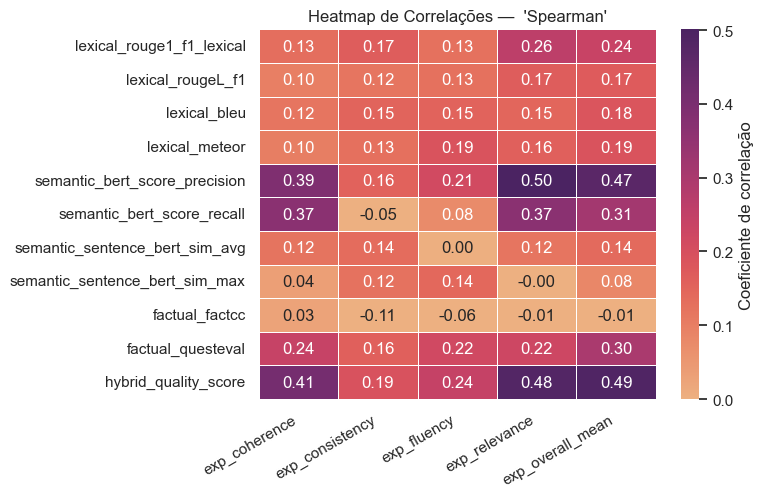

In [487]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", palette="flare")  # ou 'rocket', 'mako'…

ax = sns.heatmap(
    correlation_table_best_param,          # seu DataFrame
    cmap="flare",                          # mesma paleta do set_theme
    annot=True,                            # escreve os números na célula
    fmt=".2f",                             # arredonda para 2 casas decimais
    vmin=0,# vmax=0.4,                   # (opcional) mantém a escala coerente
    cbar_kws={"label": "Coeficiente de correlação"},
    linewidths=0.5                         # finas linhas divisórias
)
ax.set_title(f"Heatmap de Correlações —  '{constants.METHODS[0].title()}'")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")


plt.show()

In [488]:
0.49/0.47

1.0425531914893618

## Visão quebrada por tipo de modelo (Extrativo/Abstrativo)

> Extrativo

In [477]:
filter_ext = comparative_metrics_frame.model_id_tipo == "extrativos"
correlation_table_best_param_extrative = functions.get_corr(comparative_metrics_frame[filter_ext], 
                                                  constants.EVAL_COLS, 
                                                  constants.HUMAN_COLS,  
                                                  constants.METHODS)
correlation_table_best_param_extrative

,exp_coherence,exp_consistency,exp_fluency,exp_relevance,exp_overall_mean
lexical_rouge1_f1_lexical,0.348849,0.094392,0.283684,0.216027,0.353489
lexical_rougeL_f1,0.016903,0.000000,0.315410,-0.062103,0.039931
lexical_bleu,0.071210,0.056631,0.130475,-0.011494,0.067497
lexical_meteor,0.160904,0.062925,0.227996,0.064666,0.164212
semantic_bert_score_precision,0.429095,0.062919,0.339123,0.470901,0.515700
semantic_bert_score_recall,0.190758,-0.044043,0.257844,0.302532,0.284336
semantic_sentence_bert_sim_avg,-0.013528,0.025168,0.094983,-0.187084,-0.050679
semantic_sentence_bert_sim_max,-0.173724,-0.037760,0.180804,-0.348136,-0.202370
factual_factcc,0.241748,-0.163589,0.045484,0.007681,0.156315
factual_questeval,0.155686,0.195048,0.318695,0.039768,0.200277


In [479]:
comparative_metrics_frame[filter_ext].shape

(54, 28)

In [480]:
filter_ext = comparative_metrics_frame.model_id_tipo == "extrativos"
correlation_table_best_param_abstrative = functions.get_corr(comparative_metrics_frame[~filter_ext], 
                                                  constants.EVAL_COLS, 
                                                  constants.HUMAN_COLS,  
                                                  constants.METHODS)
correlation_table_best_param_abstrative

,exp_coherence,exp_consistency,exp_fluency,exp_relevance,exp_overall_mean
lexical_rouge1_f1_lexical,0.103354,0.139541,0.079161,0.296004,0.227087
lexical_rougeL_f1,0.113531,0.108189,0.085723,0.224328,0.192607
lexical_bleu,0.122391,0.139161,0.148492,0.187145,0.202391
lexical_meteor,0.095876,0.121152,0.173382,0.189323,0.198715
semantic_bert_score_precision,0.378719,0.171541,0.195975,0.507786,0.456667
semantic_bert_score_recall,0.413005,0.000671,0.086917,0.377619,0.337565
semantic_sentence_bert_sim_avg,0.144287,0.145000,-0.022889,0.177264,0.172768
semantic_sentence_bert_sim_max,0.066293,0.150462,0.143879,0.058592,0.131448
factual_factcc,-0.014186,-0.100193,-0.064852,-0.008275,-0.039486
factual_questeval,0.251337,0.152605,0.186557,0.260556,0.311886


In [420]:
comparative_metrics_frame[~filter_ext].shape

(108, 29)

In [514]:
correlation_table_best_param_abstrative.exp_overall_mean.values[:-1]

array([ 0.22708711,  0.19260721,  0.20239146,  0.19871464,  0.45666683,
        0.33756485,  0.17276814,  0.13144773, -0.03948598,  0.31188605])

In [515]:
data = {
    "metric": [
        "lexical_rouge1_f1", "lexical_rougeL_f1", "lexical_bleu", "lexical_meteor",
        "semantic_bert_score_precision", "semantic_bert_score_recall",
        "semantic_sentence_bert_sim_avg", "semantic_sentence_bert_sim_max",
        "factual_factcc", "factual_questeval"
    ],
    # valores tirados do Apêndice (abstrativo)
    "abstr":correlation_table_best_param_abstrative.exp_overall_mean.values[:-1] 
    # [
    #     0.227087, 0.192607, 0.202391, 0.198715,
    #     0.456667, 0.337565, 0.172768, 0.131448,
    #     -0.039486, 0.311886
    # ]
    ,
    # valores tirados do Apêndice (extrativo)
    "extr": correlation_table_best_param_extrative.exp_overall_mean.values[:-1]
    # [
    #     0.353489, 0.039931, 0.067497, 0.164212,
    #     0.515700, 0.284336, -0.050679, -0.202370,
    #     0.156315, 0.200277
    # ]
    ,
}

df = pd.DataFrame(data)

# --------------------------------------------------
# 2. Mapeia cada métrica para sua família
# --------------------------------------------------
family_map = {
    "lexical": df["metric"].str.startswith("lexical"),
    "semântica": df["metric"].str.startswith("semantic"),
    "factual": df["metric"].str.startswith("factual"),
}

# cria uma coluna "family" com base no dicionário acima
def infer_family(row):
    for fam, mask in family_map.items():
        if mask[row.name]:
            return fam
    return "OUTRO"

df["family"] = df.apply(infer_family, axis=1)

# --------------------------------------------------
# 3. Média por família e estrato
# --------------------------------------------------
summary = (
    df.groupby("family")[["abstr", "extr"]]
      .mean()
      .rename(columns={"abstr": "ρ_abstr", "extr": "ρ_extr"})
)
summary["Δ"] = summary["ρ_extr"] - summary["ρ_abstr"]

print("\nTabela de correlação média por família\n")
print(summary.round(3))


Tabela de correlação média por família

           ρ_abstr  ρ_extr      Δ
family                           
factual      0.136   0.178  0.042
lexical      0.205   0.156 -0.049
semântica    0.275   0.137 -0.138


# Análise do Study

In [491]:
df_study = study.trials_dataframe()

In [492]:
df_study.columns

Index(['number', 'value', 'datetime_start', 'datetime_complete', 'duration',
       'params_A1_0', 'params_A1_1', 'params_A1_2', 'params_A1_3',
       'params_A2_0', 'params_A2_1', 'params_A2_2', 'params_A2_3',
       'params_A3_0', 'params_A3_1', 'params_B1', 'params_B2', 'params_B3',
       'state'],
      dtype='object')

In [493]:
cols = ['params_B1', 'params_B2', 'params_B3']
weights = df_study[cols].astype(float)
weights.index = df_study["number"]  

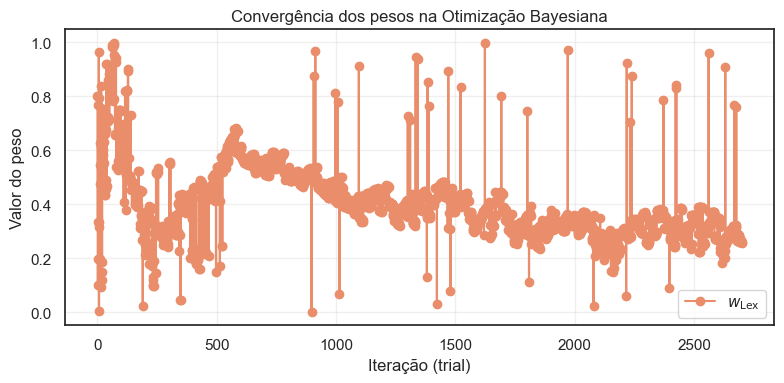

In [495]:
plt.figure(figsize=(8,4))
# for col, label in zip(cols, ["$w_{\\text{Lex}}$", "$w_{\\text{Sem}}$", "$w_{\\text{Fact}}$"]):

col = cols[0]
label = "$w_{\\text{Lex}}$"    
plt.step(weights.index, weights[col], where="mid", marker="o", label=label)

plt.xlabel("Iteração (trial)")
plt.ylabel("Valor do peso")
plt.title("Convergência dos pesos na Otimização Bayesiana")
plt.legend()
plt.grid(alpha=.3)
plt.tight_layout()
# plt.savefig("evolucao_pesos.pdf")   # ou .png


## Outro tipo com maximize

In [498]:
import numpy as np
maximize = study.direction == optuna.study.StudyDirection.MAXIMIZE
best_so_far = -np.inf if maximize else np.inf
records = []                # trials que bateram novo recorde

for t in sorted(study.trials, key=lambda x: x.number):
    if t.value is None:         # trial possivelmente interrompida
        continue
    improved = (t.value > best_so_far) if maximize else (t.value < best_so_far)
    if improved:
        best_so_far = t.value
        records.append(t)

# coloca tudo em DataFrame
best_df = pd.DataFrame({
    "trial":   [t.number for t in records],
    "score":   [t.value  for t in records],
    "w_lex":   [t.params["B1"]   for t in records],
    "w_sem":   [t.params["B2"]   for t in records],
    "w_fact":  [t.params["B3"]  for t in records],
})

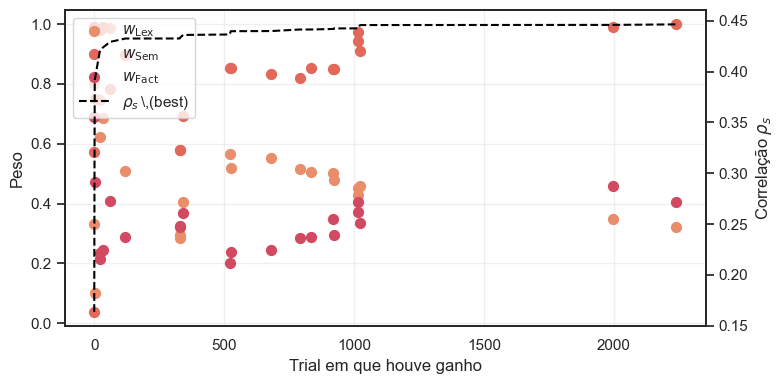

In [500]:
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

# pesos em ax1
for col, label in zip(["w_lex", "w_sem", "w_fact"],
                      [r"$w_{\text{Lex}}$", r"$w_{\text{Sem}}$", r"$w_{\text{Fact}}$"]):
    ax1.scatter(best_df["trial"], best_df[col], label=label, s=50)

# objetivo em ax2
ax2.plot(best_df["trial"], best_df["score"], "k--", lw=1.5,
         label=r"$\rho_{s}\,$\,(best)")           # << aqui estava o problema

ax1.set_xlabel("Trial em que houve ganho")
ax1.set_ylabel("Peso")
ax2.set_ylabel(r"Correlação $\rho_{s}$")
ax1.grid(alpha=.3)

# legenda combinada
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

fig.tight_layout()
# fig.savefig("pesos_e_score_melhores_trials.pdf")


C:\Users\thiago.ouverney\AppData\Local\Temp\ipykernel_17004\1077232086.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


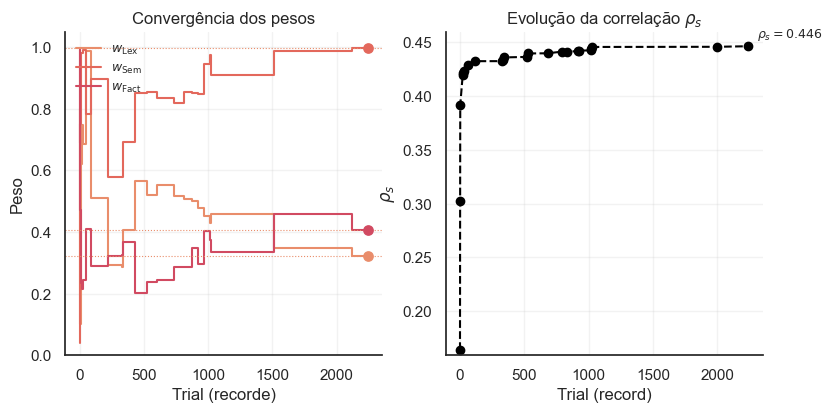

In [509]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 11})

# ------------------------------------------------------------------
# 1. Cria figura com 2 eixos horizontais
# ------------------------------------------------------------------
fig, (ax_w, ax_rho) = plt.subplots(
    1, 2, figsize=(9, 4.2),   # largura um pouco maior
    gridspec_kw=dict(wspace=0.20)  # espaço entre painéis
)

# ------------------------------------------------------------------
# 2. Painel da evolução dos PESOS
# ------------------------------------------------------------------
for col, lbl in zip(["w_lex", "w_sem", "w_fact"],
                    [r"$w_{\text{Lex}}$", r"$w_{\text{Sem}}$", r"$w_{\text{Fact}}$"]):
    ax_w.step(best_df["trial"], best_df[col], where="mid", label=lbl)
    ax_w.scatter(best_df["trial"].iloc[-1], best_df[col].iloc[-1],
                 zorder=3, s=45)

# linhas horizontais nos valores finais
for y in best_df[["w_lex", "w_sem", "w_fact"]].iloc[-1]:
    ax_w.axhline(y, ls=":", lw=.8)

ax_w.set_title("Convergência dos pesos")
ax_w.set_xlabel("Trial (recorde)")
ax_w.set_ylabel("Peso")
ax_w.set_ylim(0, 1.05)
ax_w.grid(alpha=.25)
ax_w.legend(frameon=False, fontsize=9, ncol=1, loc="upper left")
ax_w.spines[["top", "right"]].set_visible(False)

# ------------------------------------------------------------------
# 3. Painel da evolução da CORRELAÇÃO
# ------------------------------------------------------------------
ax_rho.plot(best_df["trial"], best_df["score"],
            ls="--", marker="o", color="black")
ax_rho.set_title(r"Evolução da correlação $\rho_{s}$")
ax_rho.set_xlabel("Trial (record)")
ax_rho.set_ylabel(r"$\rho_{s}$")
ax_rho.set_ylim(best_df["score"].min()*0.97, best_df["score"].max()*1.03)
ax_rho.grid(alpha=.25)
ax_rho.spines[["top", "right"]].set_visible(False)

# anotação do melhor valor
best_txt = fr"$\rho_s = {best_df['score'].iloc[-1]:.3f}$"
ax_rho.annotate(best_txt,
                xy=(best_df["trial"].iloc[-1], best_df["score"].iloc[-1]),
                xytext=(6, 6), textcoords="offset points",
                fontsize=9)

fig.tight_layout()
fig.savefig("evolucao_pesos_e_rho_lado_a_lado.png", dpi=300)  # ou .png
